In [1]:
import os
import glob
from tqdm import tqdm
import pydicom

import pandas as pd
import numpy as np

In [2]:
root = "/media/yesindeed/DATADRIVE1/mount/remote_cse/datasets/multitask-moe/CC-CCII"

df = pd.read_csv(f"{root}/lesions_slices.csv")

df

,imgpath
0,CP/3783/5727/0008.png
1,CP/3783/5727/0009.png
2,CP/3783/5727/0010.png
3,CP/3783/5727/0011.png
4,CP/3783/5727/0012.png
...,...
58761,NCP/194/1532/0061.png
58762,NCP/194/1532/0062.png
58763,NCP/194/1532/0086.png
58764,NCP/194/1532/0088.png


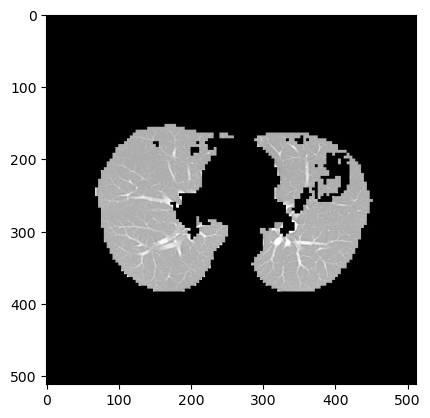

In [39]:
from PIL import Image
import matplotlib.pyplot as plt

# from scipy import misc

file = os.path.join(root, "images", "NCP/1043/2615/0023.Jpg")
img = Image.open(file).convert("RGB")
# img = plt.imread(file)

plt.imshow(img)

In [35]:
df_out = pd.read_csv(os.path.join(root, "metadata.csv"))

bmp_files = []

for img_path in df_out["path"].tolist():
    if any(img_path.endswith(x) for x in [".jpg", ".JPG", ".png", ".bmp", ".BMP", ".jpeg", ".tif", ".Jpg"]):
        continue
    else:
        bmp_files.append(img_path)

print(bmp_files)
len(bmp_files)

['./images/NCP/945/2488/0032.Jpg', './images/NCP/945/2488/0024.Jpg', './images/NCP/942/2485/0044.Jpg', './images/NCP/945/2488/0020.Jpg', './images/NCP/945/2488/0043.Jpg', './images/NCP/942/2485/0007.Jpg', './images/NCP/1043/2615/0003.Jpg', './images/NCP/945/2488/0041.Jpg', './images/NCP/1043/2615/0017.Jpg', './images/NCP/942/2485/0042.Jpg', './images/NCP/942/2485/0012.Jpg', './images/NCP/942/2485/0017.Jpg', './images/NCP/945/2488/0015.Jpg', './images/NCP/945/2488/0014.Jpg', './images/NCP/1043/2615/0006.Jpg', './images/NCP/945/2488/0012.Jpg', './images/NCP/945/2488/0018.Jpg', './images/NCP/1043/2615/0014.Jpg', './images/NCP/945/2488/0013.Jpg', './images/NCP/945/2488/0028.Jpg', './images/NCP/945/2488/0031.Jpg', './images/NCP/942/2485/0038.Jpg', './images/NCP/945/2488/0016.Jpg', './images/NCP/942/2485/0035.Jpg', './images/NCP/1043/2615/0041.Jpg', './images/NCP/942/2485/0023.Jpg', './images/NCP/1043/2615/0027.Jpg', './images/NCP/1043/2615/0026.Jpg', './images/NCP/1043/2615/0045.Jpg', './im

135

In [3]:
all_files = glob.glob(os.path.join(root, "images", "*", "*", "*", "*"))

In [ ]:
dict_out = {"id": [], "exam_id": [], "path": [],
            "class": [], "exam_class": [], "patient": []}

class_mapping = {
    "Normal": "no findings",
    "CP": "typical appearance pneumonia",
    "NCP": "atypical appearance pneumonia",
}

for img_file in tqdm(all_files):
    diagnosis, patient_id, subject_id, img = img_file.split("/")[-4:]

    id = f"{diagnosis}/{patient_id}/{subject_id}/{img}"

    dict_out["id"].append(id)
    dict_out["exam_id"].append(f"{patient_id}/{subject_id}")

    dict_out["path"].append(
        f"./images/{diagnosis}/{patient_id}/{subject_id}/{img}")

    cls = class_mapping[diagnosis]

    dict_out["exam_class"].append(cls)

    if id in df["imgpath"].tolist():
        dict_out["class"].append(cls)
    else:
        dict_out["class"].append("no findings")

    dict_out["patient"].append(patient_id)

    # break

df_out = pd.DataFrame.from_dict(dict_out)
df_out.head()

  0%|          | 0/411529 [00:00<?, ?it/s]

100%|██████████| 411529/411529 [08:20<00:00, 822.11it/s] 


,id,exam_id,path,class,exam_class,patient
0,CP/0/3138/0227.png,0/3138,./images/CP/0/3138/0227.png,no findings,typical appearance pneumonia,0
1,CP/0/3138/0238.png,0/3138,./images/CP/0/3138/0238.png,no findings,typical appearance pneumonia,0
2,CP/0/3138/0194.png,0/3138,./images/CP/0/3138/0194.png,no findings,typical appearance pneumonia,0
3,CP/0/3138/0013.png,0/3138,./images/CP/0/3138/0013.png,no findings,typical appearance pneumonia,0
4,CP/0/3138/0172.png,0/3138,./images/CP/0/3138/0172.png,no findings,typical appearance pneumonia,0


In [12]:
import numpy as np

df_out["dataset"] = "CC-CCII"
df_out["class_num"] = 3
df_out["contains_negative"] = 1
df_out["modality"] = "ct"

df_out = df_out.sample(frac=1).reset_index(drop=True)

patients = df_out["patient"].unique()
patient_size = len(patients)

test_indices = np.random.choice(list(range(patient_size)), int(patient_size * 0.15), replace=False)

test_patients = patients[test_indices]

df_out["split"] = "train"

df_out.loc[df_out["patient"].isin(test_patients), "split"] = "test"

In [13]:
df_out = df_out.drop("patient", axis=1)

df_out.to_csv(f"{root}/metadata.csv", index=False)